In [1]:
import sys
import import_ipynb
from pathlib import Path
from scipy.sparse.linalg import spsolve
from IPython.display import SVG, display

# Adicionar o diretório raiz do projeto ao sys.path
project_root = Path().resolve().parent  
sys.path.append(str(project_root))
print("Project root added to sys.path:", project_root)

# Importando notebooks diretamente
try:
    import problem_statement as ps  
    from fem_pos_processing import graph_results
    print("Modules imports were successful!")
except ModuleNotFoundError as en:
    print(f"Modules were not found: {en}")
except ImportError as en:
    print(f"Error in import: {en}")

Project root added to sys.path: C:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF
Todas as propriedades foram verificadas com sucesso para os elementos P1!
Todas as propriedades foram verificadas com sucesso para os elementos P2!
Todas as propriedades foram verificadas com sucesso para os elementos P3!
Todas as propriedades foram verificadas com sucesso para os elementos Q1!
Todas as propriedades foram verificadas com sucesso para os elementos Q2!
Modules imports were successful!


# Project 4: Vectorial Poisson Problem at Rectangular Domain $\Omega = [-1,1]^2$

Considere um problema vetorial de _Poisson_ 2D em $\Omega = [-1,1]^2$

$$
\nabla \times \nabla \times \mathbf{u}(\mathbf{x}) + a \mathbf{u}(\mathbf{x}) =
\mathbf{f}(\mathbf{x}) \quad \text{em} \; \Omega = [-1, 1]^2
\tag{1}
$$

$$
\hat{n} \times \mathbf{u} = 0 \quad \text{em} \; \partial \Omega
$$

onde a fonte é dada por,
$$
\mathbf{f}(x,y) = (2\pi^2 + 1)\, 
\begin{pmatrix}
cos(\pi x)  sin(\pi y) \\
-sin(\pi x)  cos(\pi y) \\
\end{pmatrix}
\tag{2}
$$

A solução analítica deste problema é

$$
\mathbf{u}(x,y) = 
\begin{pmatrix}
cos(\pi x)  sin(\pi y) \\
-sin(\pi x)  cos(\pi y) \\
\end{pmatrix}
\tag{3}
$$

Implemente um programa de elementos finitos utilizando elementos de _Nedelec_ do tipo 1, $N_0$, em $R^2$ para resolver o Problema de Valor de Contorno vetorial $(1)$.

# 3-noded Linear Triangular Elements, $P_1$
## Pre-processor module
## Geometry and mesh Domain

In [2]:
FINITE_ELEMENT = ("Triangle", 1)
BOUNDARY = [{'tag': 101, 'type': 'Dirichlet', 'value': 0.0, 'name': 'entire_boundary'}]
MATERIAL = [{'tag': 201, 'name': 'free_space', 'a': 1}]

# Create mesh from file geometry
h = 0.1
mesh_data = ps.create_meshed_domain(FINITE_ELEMENT, BOUNDARY, MATERIAL, h, view_mesh=False)

Malha salva em pre_processing/mesh/vectorial_poisson_domain_Triangle1.msh
Model vectorial_poisson (2D)
Info     : 9 geometric entities
Info     : 2 Physical Groups
Info     : 514 nodes in total
Info     : 946 2 elements in total


# Figure 1: Meshed domain

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p41_vectorial_problem\pre_processing\pictures\meshed_domain_Triangle1_EntireDomain.svg


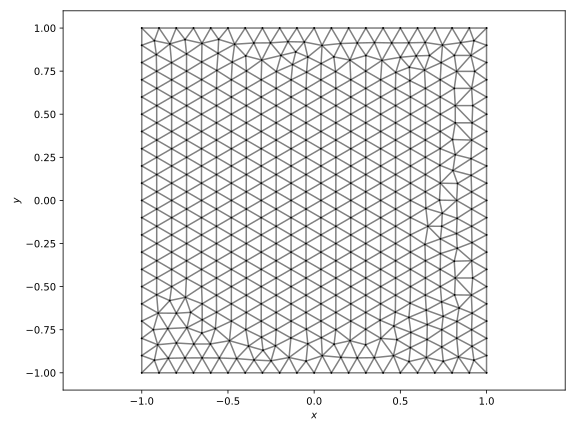

In [3]:
INFO_GRAPH = {'cell': False, 'nodes': False, 'edges': False, 'edges_numb': False}
graph_results.plot_mesh(FINITE_ELEMENT, INFO_GRAPH, mesh_data)
display(SVG(filename="pre_processing/pictures/meshed_domain_Triangle1_EntireDomain.svg"))

# FEM Formulation

## `assembly.global_matrices()`

In [4]:
import numpy as np
from scipy.sparse import lil_matrix
from fem_processing import gaussian_quadrature
from fem_processing import master_domain

# Inicializa a matriz global como uma matriz esparsa zero (tamanho NxN)
Nedges = len(mesh_data['edges'])
Sg = lil_matrix((Nedges, Nedges), dtype='complex128')
Mg = lil_matrix((Nedges, Nedges), dtype='complex128')
bg = lil_matrix((Nedges, 1), dtype='complex128')

# Início do processo de montagem
for cell in mesh_data['cell'].values(): 
    # Initialize the local matrices
    Ne = len(cell['conn_edge'])
    Se = np.zeros((Ne, Ne), dtype='complex128') # Matriz de rigidez do elemento
    Me = np.zeros((Ne, Ne), dtype='complex128') # Matriz de massa do elemento
    be = np.zeros((Ne, 1), dtype='complex128')  # Vetor de carga do elemento

    # Material properties
    pe = cell['p(x)']
    qe = np.eye(3)
    fe = np.vstack((cell['f(x)'], [[0]]))

    # Cálculo da matriz Jacobiana Completa 3x3
    # Je = assembly.jacobian(mesh_data, cell)
    Je = np.eye(3)
    Je[:2, :2] = cell['geo']['jacobian']

    # Rotacional das funções de forma
    curl_phi_hat = [
        np.array([[0], [0], [2]]),
        np.array([[0], [0], [-2]]),
        np.array([[0], [0], [2]])
    ]

    # Determinante e inversa transposta do Jacobiano
    Jdet, JinvT = np.abs(np.linalg.det(Je)), np.linalg.inv(Je).T 
    
    # Tensor Métrico Covariante
    # Produto interno dos vetores coluna de Je: t1 dot t2
    Gt = Je.T @ Je

    # Tensor métrico contravariante
    Gn = JinvT.T @ JinvT

    # Integração numérica
    gauss_points, gauss_weights = gaussian_quadrature.gauss_data(FINITE_ELEMENT)
    for xik, wk in zip(gauss_points, gauss_weights):
        # print(f"xik: {xik}, wk: {wk}")
        # Função de forma vetorial no ponto de integração
        phi_hat = master_domain.shape_functions_nedelec_3d(*xik)

        for i in range(Ne):
            # Transformação de Piola Covariante
            phi_i = qe @ JinvT @ phi_hat[i]
            curl_phi_i = pe * 1/Jdet * Je @ curl_phi_hat[i]

            # Vetor de cargas
            be[i] += (fe.T @ phi_i).item() * Jdet * wk
            
            for j in range(Ne):
                # Transformação de Piola Covariante
                phi_j = JinvT @ phi_hat[j]
                curl_phi_j = 1/Jdet * Je @ curl_phi_hat[j]

                # Matriz de rigidez
                # Se[i, j] =+ (curl_phi_hat[i].T @ Gt @ curl_phi_hat[j]).item() * (1/Jdet) * wk
                Se[i, j] += (curl_phi_i.T @ curl_phi_j).item() * Jdet * wk

                # Matriz de massa
                # Me[i, j] += (phi_i.T @ phi_j).item() * Jdet * wk
                Me[i, j] += (phi_hat[i].T @ Gn @ phi_hat[j]).item() * Jdet * wk

    # Matriz de rigidez do elemento
    Se1 = (1/Jdet) * (0.5) * np.array([
        [4, -4, 4], 
        [-4, 4, -4],
        [4, -4, 4]
    ])

    # Verifica se as matrizes são iguais
    # print(np.allclose(Se, Se1, atol=1e-8, rtol=1e-8))
    # print(np.allclose(Me1, Me2, atol=1e-8, rtol=1e-8))

    # loop sobre os nós locais de cada elemento
    for i, ig in enumerate(cell['conn_edge']):
        ig = int(ig)-1
        for j, jg in enumerate(cell['conn_edge']):
            jg = int(jg)-1
            Sg[ig, jg] += Se[i, j]
            Mg[ig, jg] += Me[i, j]
            
        # preenche o vetor global b
        bg[ig, 0] += be[i]

## `apply_simple_dirichlet()`

In [5]:
for key, edge in mesh_data['edges'].items():
    # Verifica se a aresta é de Dirichlet
    if edge['bc']['type'] == 'Dirichlet':
        e = int(key) - 1
        
        # Zera a linha correspondente a aresta de Dirichlet
        Sg[e, :] = 0
        Mg[e, :] = 0
        
        # Define o valor 1 na diagonal para evitar singularidade
        Sg[e, e] = 0.5
        Mg[e, e] = 0.5
        
        # Ajusta o vetor de forças com o valor de Dirichlet
        bg[e] = edge['bc']['value']

In [6]:
# Global matrices assembling
# Sg, fg, Mg = assembly.global_matrices(FINITE_ELEMENT, mesh_data)

# # Apply boundary conditions
# Sg, fg = assembly.apply_simple_dirichlet(Sg, fg, mesh_data)

# Solve the linear system
Ag = Sg + Mg

# Solução do problema matricial
curl_uh = spsolve(Ag.tocsr(), bg.toarray())

# Criar o dicionário da solução numérica
curl_uh = {key+1: value for key, value in enumerate(curl_uh)}

## Interpolate solution

In [7]:
uh_at_cell = ps.interpolate_solution(mesh_data, curl_uh, xik_master=(1/3, 1/3))

# Figure 2: Numerical solution at $\partial{\Omega_c}$

Arquivo salvo em: c:\Users\adilt\OneDrive\05_GIT\PPGEE-2024.2-MEF\p41_vectorial_problem\pos_processing\pictures\vectorial_fem_solution_Triangle1_EntireDomain.svg


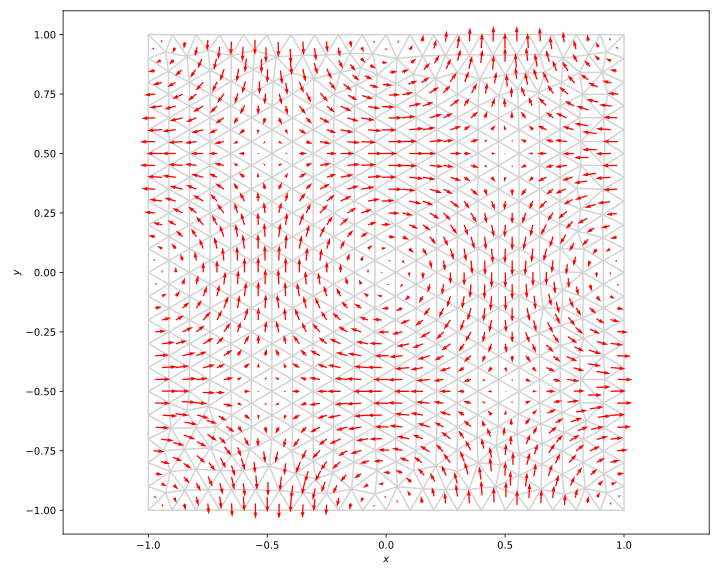

In [8]:
graph_results.vectorial_fem_solution(FINITE_ELEMENT, mesh_data, uh_at_cell)
display(SVG(filename="pos_processing/pictures/vectorial_fem_solution_Triangle1_EntireDomain.svg"))

Conversão do arquivo Jupyter Notebook para um script Python: ``python -m nbconvert --to script name.ipynb``

Belo Horizonte, Brazil. 2025.  
Adilton Junio Ladeira Pereira - adt@ufmg.br  
&copy; All rights reserved.